<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/SVD%EB%A5%BC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EA%B3%BC_%EC%82%AC%EC%9D%B4%ED%82%A5%EB%9F%B0%EC%9C%BC%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

178


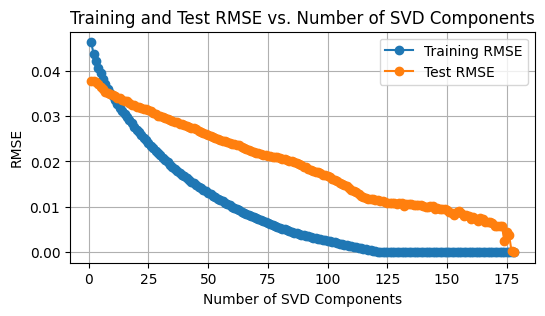

In [13]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv('user_place_data_240429.csv')

# 피벗테이블 생성
pivot_table = df.pivot(index='User Id', columns='Place Id', values='Rating')

# 결측치 처리
pivot_table_filled = pivot_table.apply(lambda x: x.fillna(x.mean()), axis=1)

# 데이터 배열로 변환
ratings_matrix = pivot_table_filled.values

# 훈련 데이터와 테스트 데이터로 나누기
train_data, test_data = train_test_split(ratings_matrix, test_size=0.3, random_state=42)

# RMSE를 저장할 리스트 초기화
train_rmse_list = []
test_rmse_list = []

# SVD의 컴포넌트 수에 따른 반복
n_components_range = range(1, 179)
for n_components in n_components_range:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(train_data)

    # 훈련 데이터와 테스트 데이터에 대한 예측
    train_predictions = svd.inverse_transform(svd.transform(train_data))
    test_predictions = svd.inverse_transform(svd.transform(test_data))

    # 예측평점은 5를 안넘음
    train_predictions = np.clip(train_predictions, 1, 5)
    test_predictions = np.clip(test_predictions, 1, 5)

    # 훈련 데이터와 테스트 데이터의 RMSE 계산
    train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(test_data, test_predictions))

    # RMSE 결과 저장
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

# 최적의 k : train_rmse와 test_rmse가 수렴하는값
optimal_k = n_components_range[np.argmin(np.abs(np.array(train_rmse_list) - np.array(test_rmse_list)))]

print(optimal_k)

# 최적의 SVD 모델
svd_optimal = TruncatedSVD(n_components=optimal_k, random_state=42)
svd_optimal.fit(train_data)

# RMSE 시각화
plt.figure(figsize=(6, 3))
plt.plot(n_components_range, train_rmse_list, marker='o', label='Training RMSE')
plt.plot(n_components_range, test_rmse_list, marker='o', label='Test RMSE')
plt.title('Training and Test RMSE vs. Number of SVD Components')
plt.xlabel('Number of SVD Components')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
train_data.shape

(2106, 178)

In [15]:
# 최적의 k 19로 다시 훈련
svd_optimal = TruncatedSVD(n_components=178, random_state=42)
svd_optimal.fit(train_data)

TruncatedSVD(n_components=178, random_state=42)

In [17]:
# 성능 계산
train_predictions = svd_optimal.inverse_transform(svd_optimal.transform(train_data))
test_predictions = svd_optimal.inverse_transform(svd_optimal.transform(test_data))

train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions))
test_rmse = np.sqrt(mean_squared_error(test_data, test_predictions))

print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

# mse
train_mse = mean_squared_error(train_data, train_predictions)
test_mse = mean_squared_error(test_data, test_predictions)

print("Training MSE:", train_mse)
print("Test MSE:", test_mse)

# 정확도
train_accuracy = 1 - train_rmse
test_accuracy = 1 - test_rmse

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training RMSE: 5.522153769843024e-15
Test RMSE: 5.516582600093595e-15
Training MSE: 3.049418225779152e-29
Test MSE: 3.043268358365541e-29
Training Accuracy: 0.9999999999999944
Test Accuracy: 0.9999999999999944


In [6]:
# 전체 데이터에 대한 예측 평점 계산
all_predictions = svd_optimal.inverse_transform(svd_optimal.transform(ratings_matrix))


In [7]:
# df에 가장 번호가 많은 유저 찾기
user_id = df['User Id'].value_counts().idxmax()
user_id

17

In [18]:
# User ID 의 실제 평점과 예측 평점 비교
user_index = pivot_table.index.get_loc(user_id)

# 실제와 예측 평점 데이터프레임 생성
actual_ratings = pivot_table.iloc[user_index]
predicted_ratings = pd.Series(all_predictions[user_index], index=pivot_table.columns)

# 예측 평점의 숫자가 1-5사이로 제한
predicted_ratings = predicted_ratings.clip(lower=1, upper=5)

# 실제 평점과 예측 평점 비교
comparison_df = pd.DataFrame({
    'Actual Rating': actual_ratings,
    'Predicted Rating': predicted_ratings
}).dropna()

# 실제 평점과 예측 평점 비교 출력 (상위 5개)
print(comparison_df.head(5))


          Actual Rating  Predicted Rating
Place Id                                 
5                   1.0               1.0
6                   5.0               5.0
7                   5.0               5.0
9                   5.0               5.0
12                  2.0               2.0


Text(0.5, 1.0, 'Actual Ratings vs. Predicted Ratings')

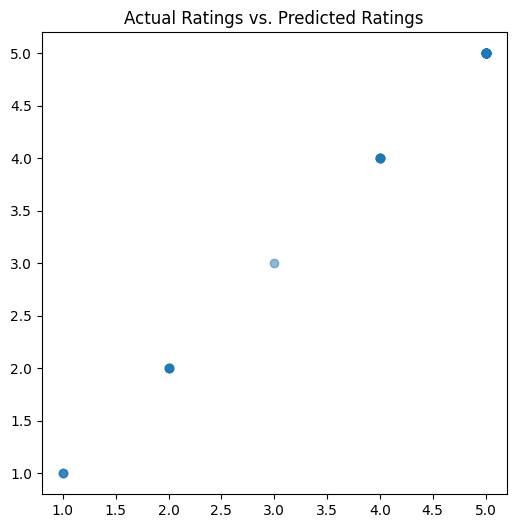

In [19]:
# 시각화
plt.figure(figsize=(6, 6))
plt.scatter(actual_ratings, predicted_ratings, alpha=0.5)
plt.title('Actual Ratings vs. Predicted Ratings')

In [20]:
# 전체데이터에서 user_id 17이 평점이 없는 데이터

user_index = pivot_table.index.get_loc(user_id)
missing_ratings = pivot_table.iloc[user_index].isnull()

# user_id 1이 평점이 없는 데이터 출력
# print(pivot_table.iloc[user_index][missing_ratings])

# 예측평점 구하기
predicted_ratings = pd.Series(all_predictions[user_index], index=pivot_table.columns)

# 예측평점 최솟값은 1로, 최댓값은 5로 설정
predicted_ratings = predicted_ratings.clip(lower=1, upper=5)

# 데이터프레임으로 출력
print(predicted_ratings.to_frame())

# 예측평점이 높은 순서대로 출력
print(predicted_ratings.sort_values(ascending=False))

# Place Id, Pred Rating 두 개의 칼럼이있는 데이터프레임으로 저장

your_df = pd.DataFrame(predicted_ratings.to_frame())

print(your_df)



                 0
Place Id          
0         4.307692
1         4.307692
2         4.307692
3         4.307692
4         4.307692
...            ...
173       4.307692
174       4.307692
175       4.307692
176       4.307692
177       5.000000

[178 rows x 1 columns]
Place Id
119    5.0
133    5.0
137    5.0
21     5.0
20     5.0
      ... 
146    2.0
23     2.0
95     1.0
128    1.0
5      1.0
Length: 178, dtype: float64
                 0
Place Id          
0         4.307692
1         4.307692
2         4.307692
3         4.307692
4         4.307692
...            ...
173       4.307692
174       4.307692
175       4.307692
176       4.307692
177       5.000000

[178 rows x 1 columns]


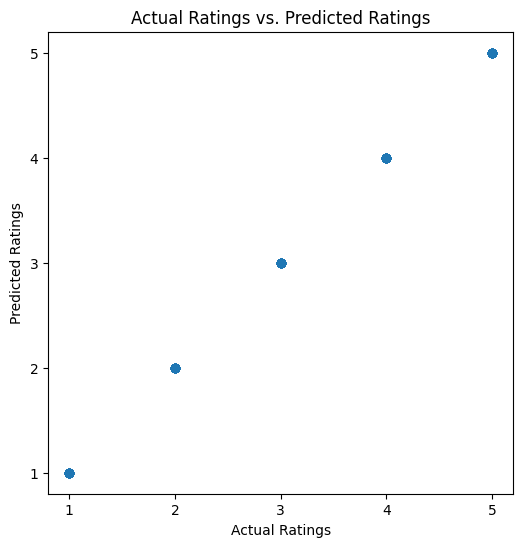

In [21]:
# 모든 유저의 예측평점
all_predictions = svd_optimal.inverse_transform(svd_optimal.transform(ratings_matrix))

# 모든 유저의 실제평점
all_actual_ratings = pivot_table

# 시각화
plt.figure(figsize=(6, 6))
plt.scatter(all_actual_ratings.values, all_predictions, alpha=0.1)
plt.title('Actual Ratings vs. Predicted Ratings')
# 간격은 1씩
plt.xticks(np.arange(1, 6, 1))
plt.yticks(np.arange(1, 6, 1))
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

# 전체 데이터에 대한 예측 평점 계산
all_predictions = svd_optimal.inverse_transform(svd_optimal.transform(ratings_matrix))
